##### import all libraries

In [97]:
import os
import h5py
import re
import random
from scipy.io import loadmat
import numpy as np
from preproc import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from dPCA import dPCA
from sklearn.manifold import Isomap
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import directed_hausdorff
from itertools import combinations
from scipy.special import factorial
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy.stats import mannwhitneyu
from statsmodels.multivariate.manova import MANOVA
import pandas as pd
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
from IPython.display import HTML
import textwrap
import pickle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



#### load data from day_list.txt or a single day

In [65]:
day_list = ['20181105']
#day_list = ['20181105', '20181102', '20181101']

#day_list = list()
#with open(f'data/combined/days.txt', 'r') as file:
#    for line in file:
#        day_list.append(line.strip())

In [66]:
# Common constants
popl_name = '364 cells'

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1
num_days = 67

In [67]:
# Common functions
def group_by_trajectory(timeseries: np.array, trajectories: np.array) -> list:
    # num_goals = 6
    grouped = {(i+1, j+1): list() for j in range(num_goals) for i in range(num_goals) if i != j}
    for idx, traj in enumerate(trajectories):
        goal1, goal2 = int(traj[0]), int(traj[1])
        if goal1 == 0:
            continue
        grouped[(goal1, goal2)].append(timeseries[idx])
    return grouped

In [68]:
# Read in predefined list of cells
good_cell_labels = list()

with open('data/cell_list_hm.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        good_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')


In [69]:
place_cell_labels = list()
with open('sigcells/place_cells.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        place_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
# View cells
view_cell_labels = list()
with open('sigcells/view_cells.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        view_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
# Merge and remove duplicates from both lists
pv_cell_labels = list(set(place_cell_labels).union(set(view_cell_labels)))

In [70]:
save_dir = 'data/placedist'

### By cell:
Group by cell 

In [71]:
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()


for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        all_place_responses.extend(data['place_responses_per_cell'])
        for _ in range(num_sess_cells):
            all_place_durations.append(data['durations_per_place'])
        all_cell_labels.extend(data['cell_labels'])
num_all_cells = len(all_cell_labels)

In [72]:
# Read in predefined list of cells
good_cell_labels = list()
with open('data/cell_list_pseudopop.txt', 'r') as file:
    for line in file:
        good_cell_labels.append(line.rstrip())

# Filter out cells not in pseudopopulation list
cell_filter = np.array([idx for idx, cell in enumerate(all_cell_labels) if cell in set(good_cell_labels)])
all_place_responses = [all_place_responses[i] for i in cell_filter]
all_place_durations = [all_place_durations[i] for i in cell_filter]

# Update num_all_cells and all_cell_labels to reflect number of cells in pseudopopulation
num_all_cells = cell_filter.shape[0]
all_cell_labels = [all_cell_labels[i] for i in cell_filter]

print("Number of Cells in PseudoPopulation:", num_all_cells)
print("All Cell Labels:", all_cell_labels)

Number of Cells in PseudoPopulation: 6
All Cell Labels: ['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c2', '20181105ch43c3', '20181105ch45c1']


/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


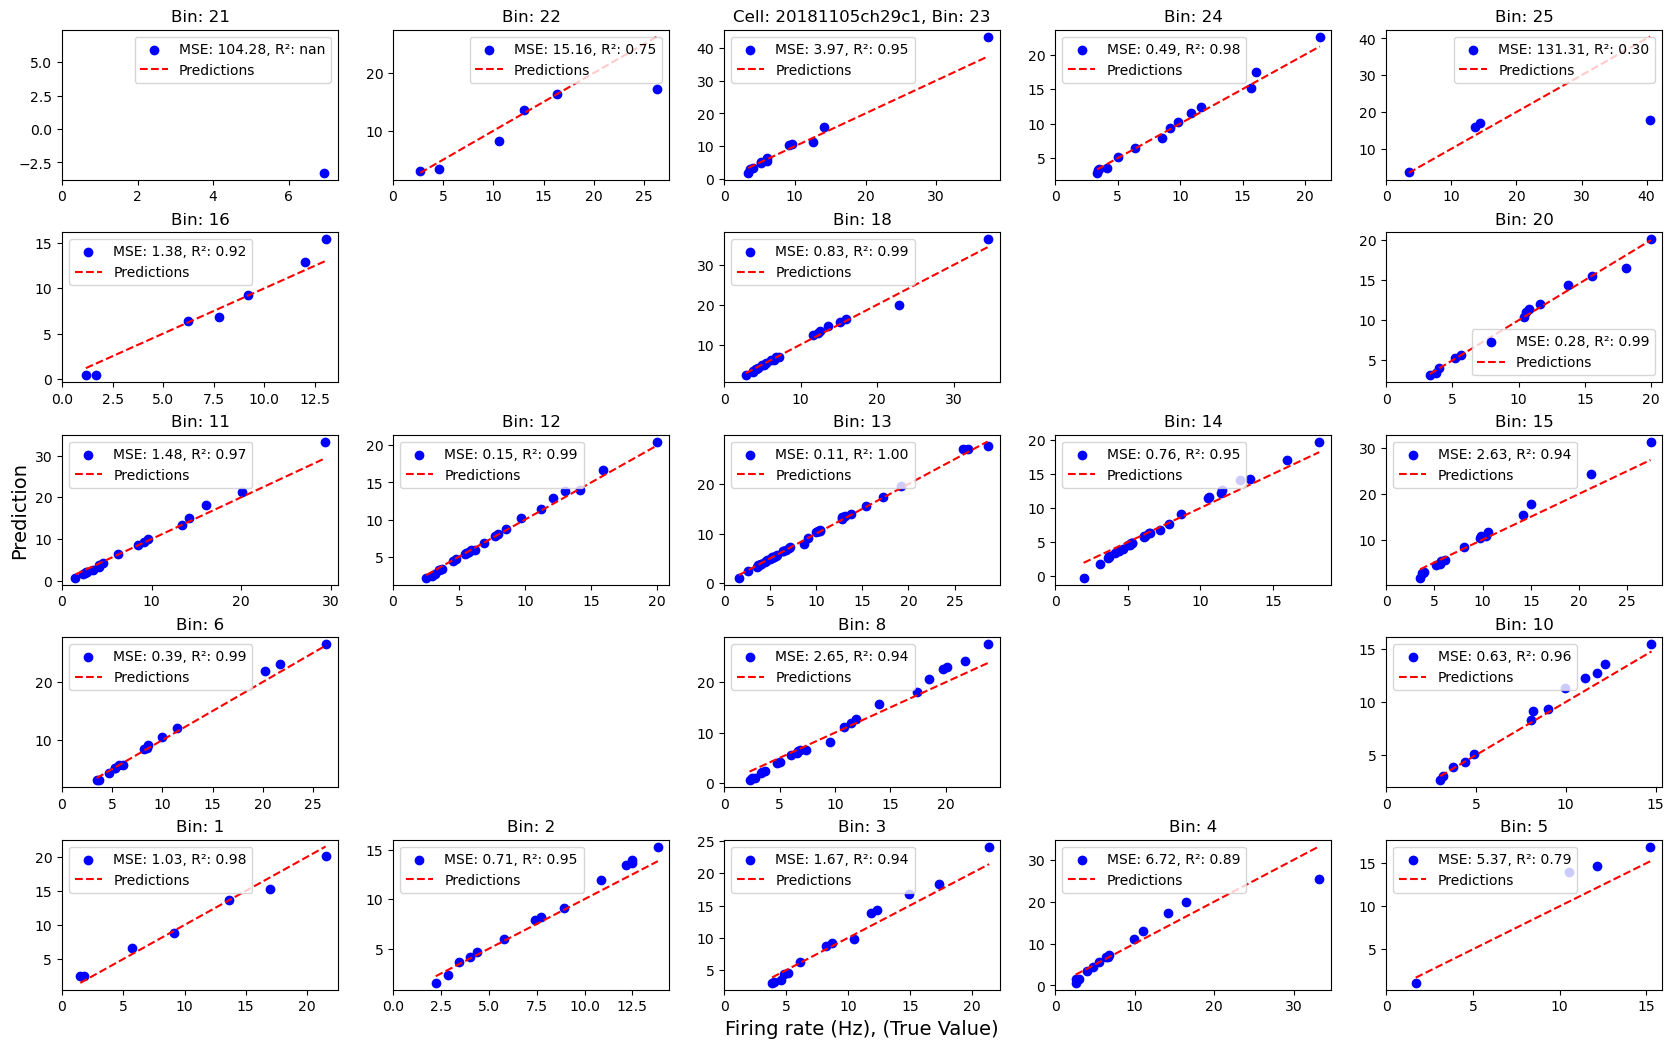

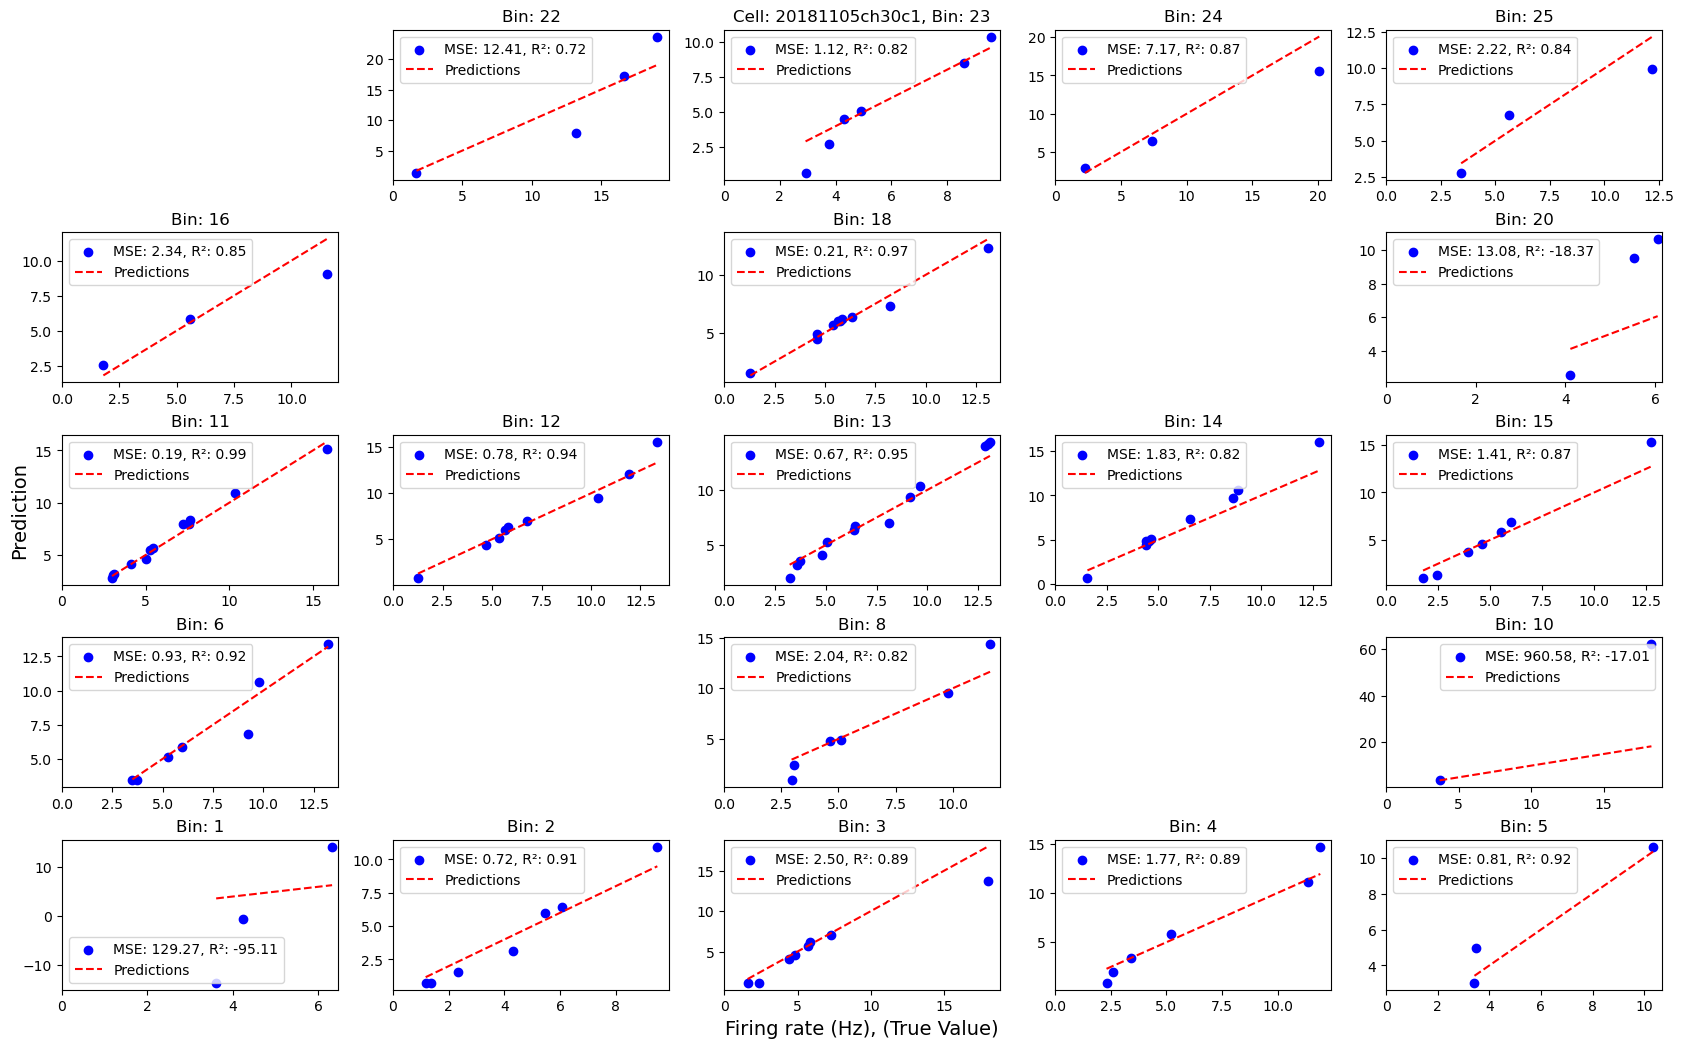

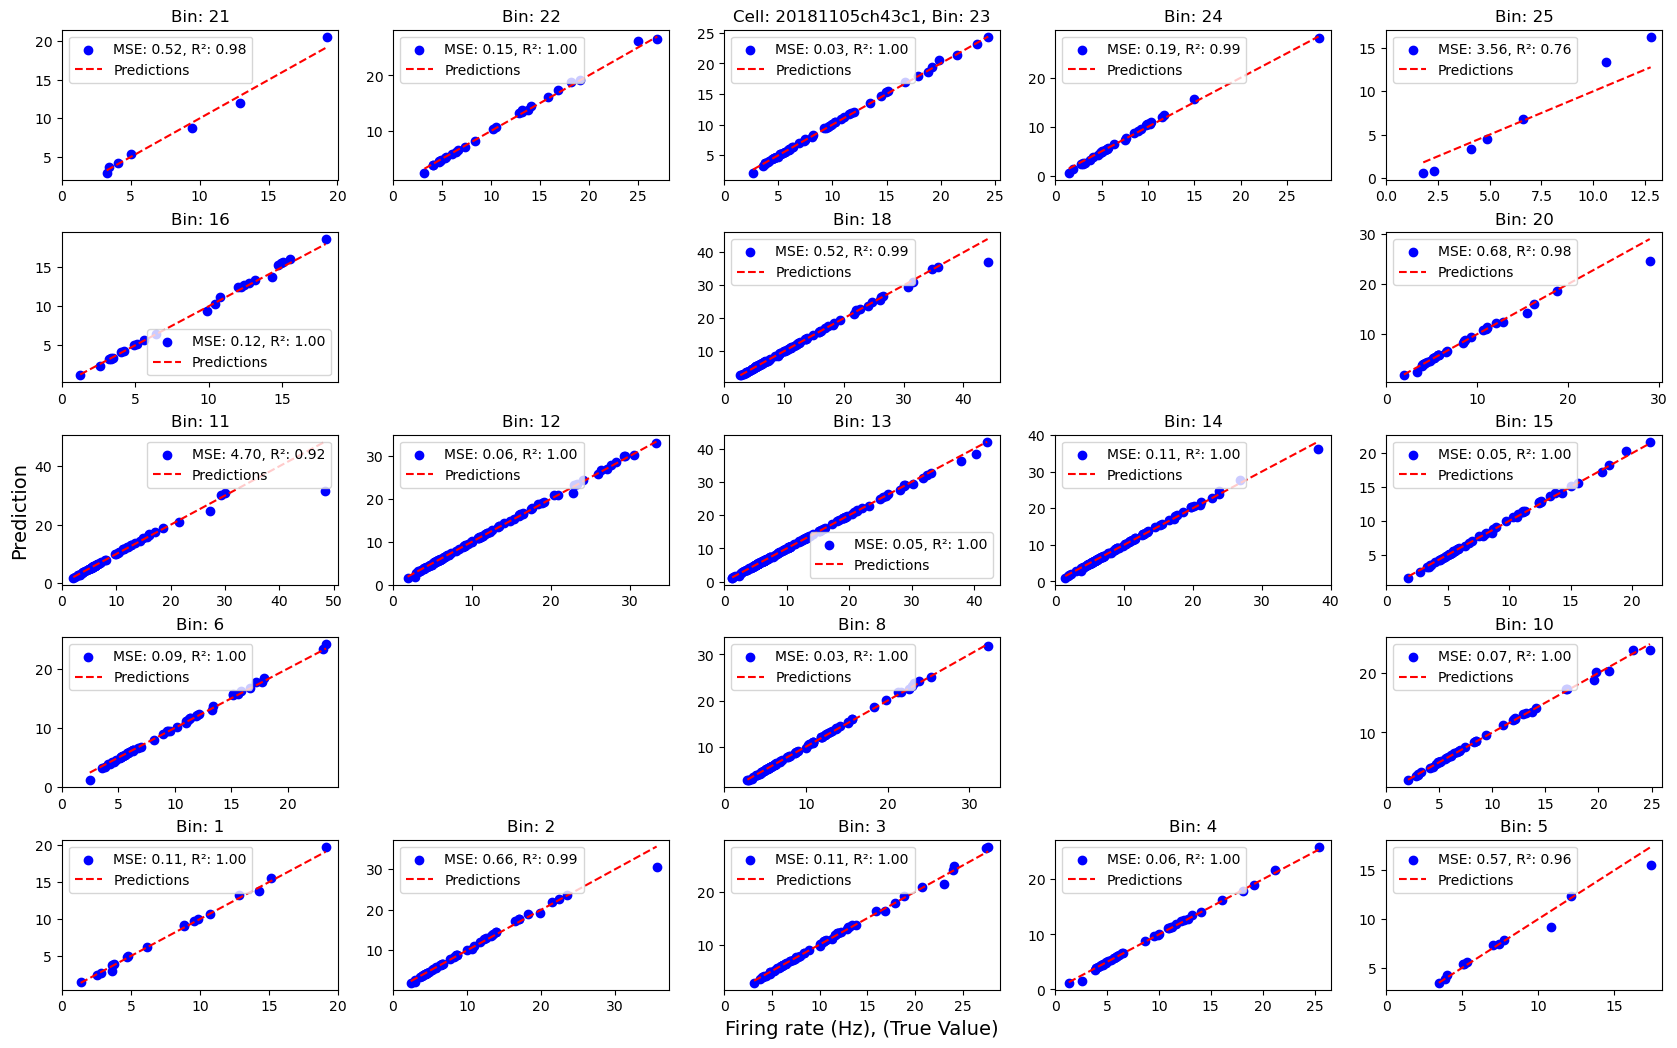

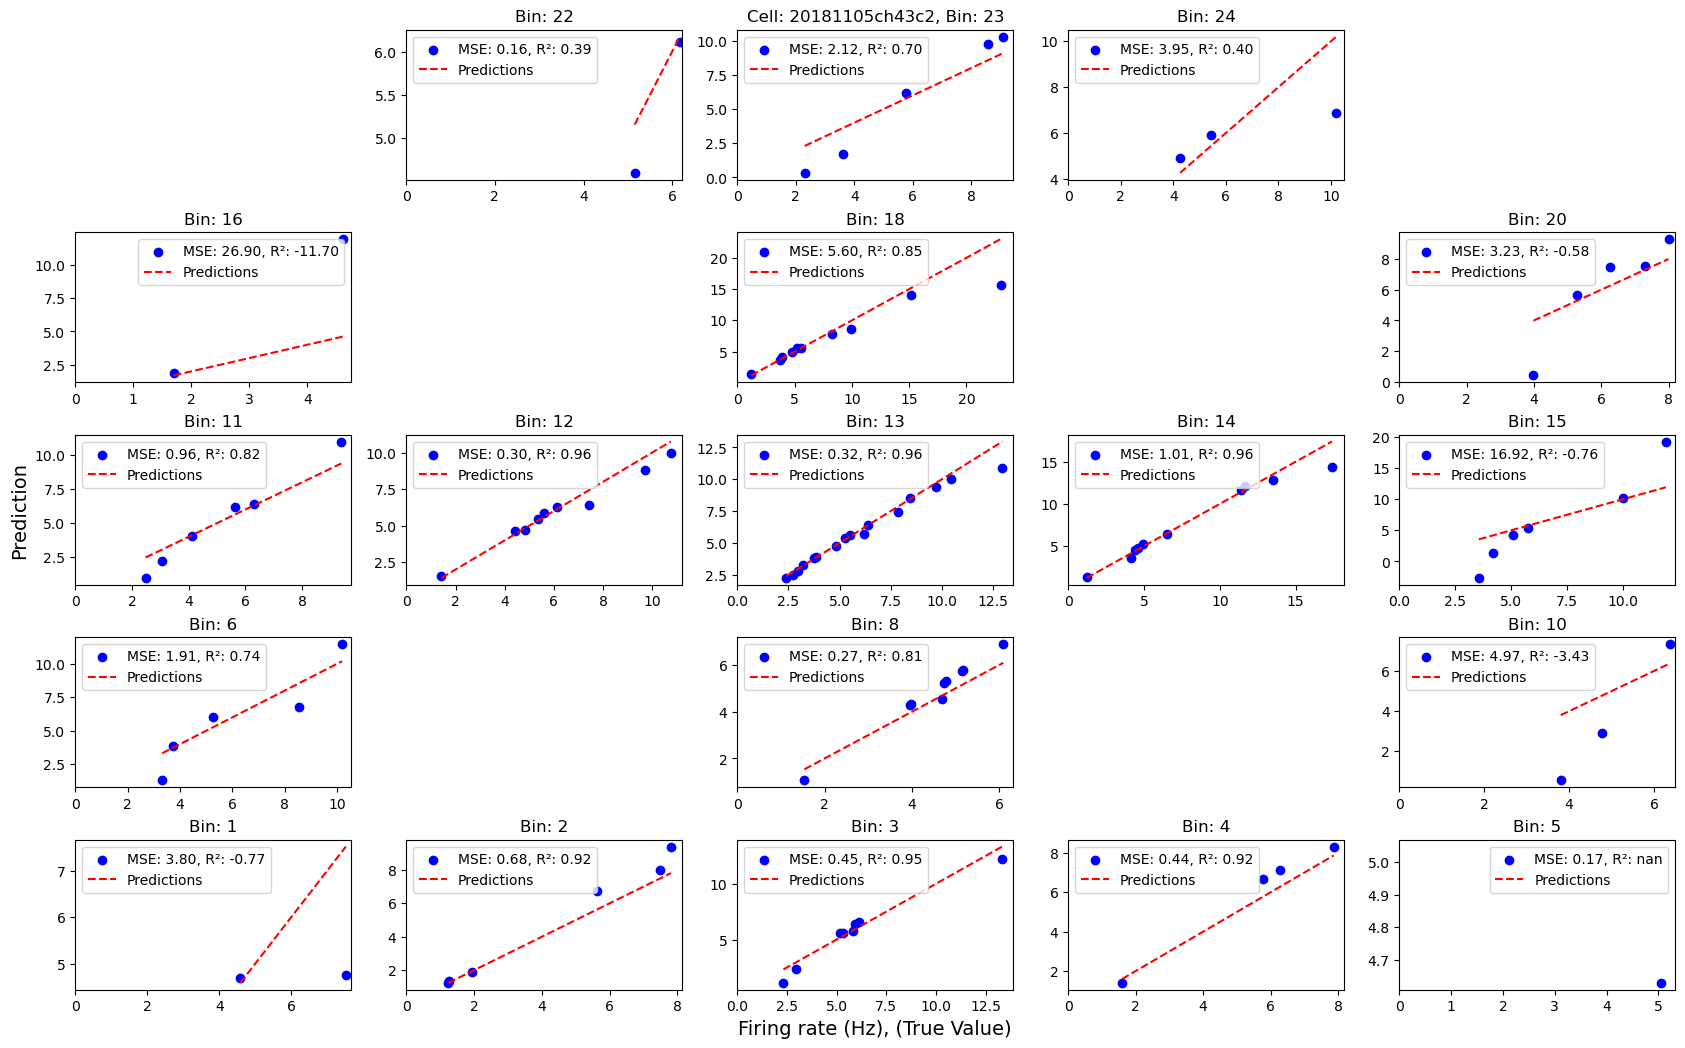

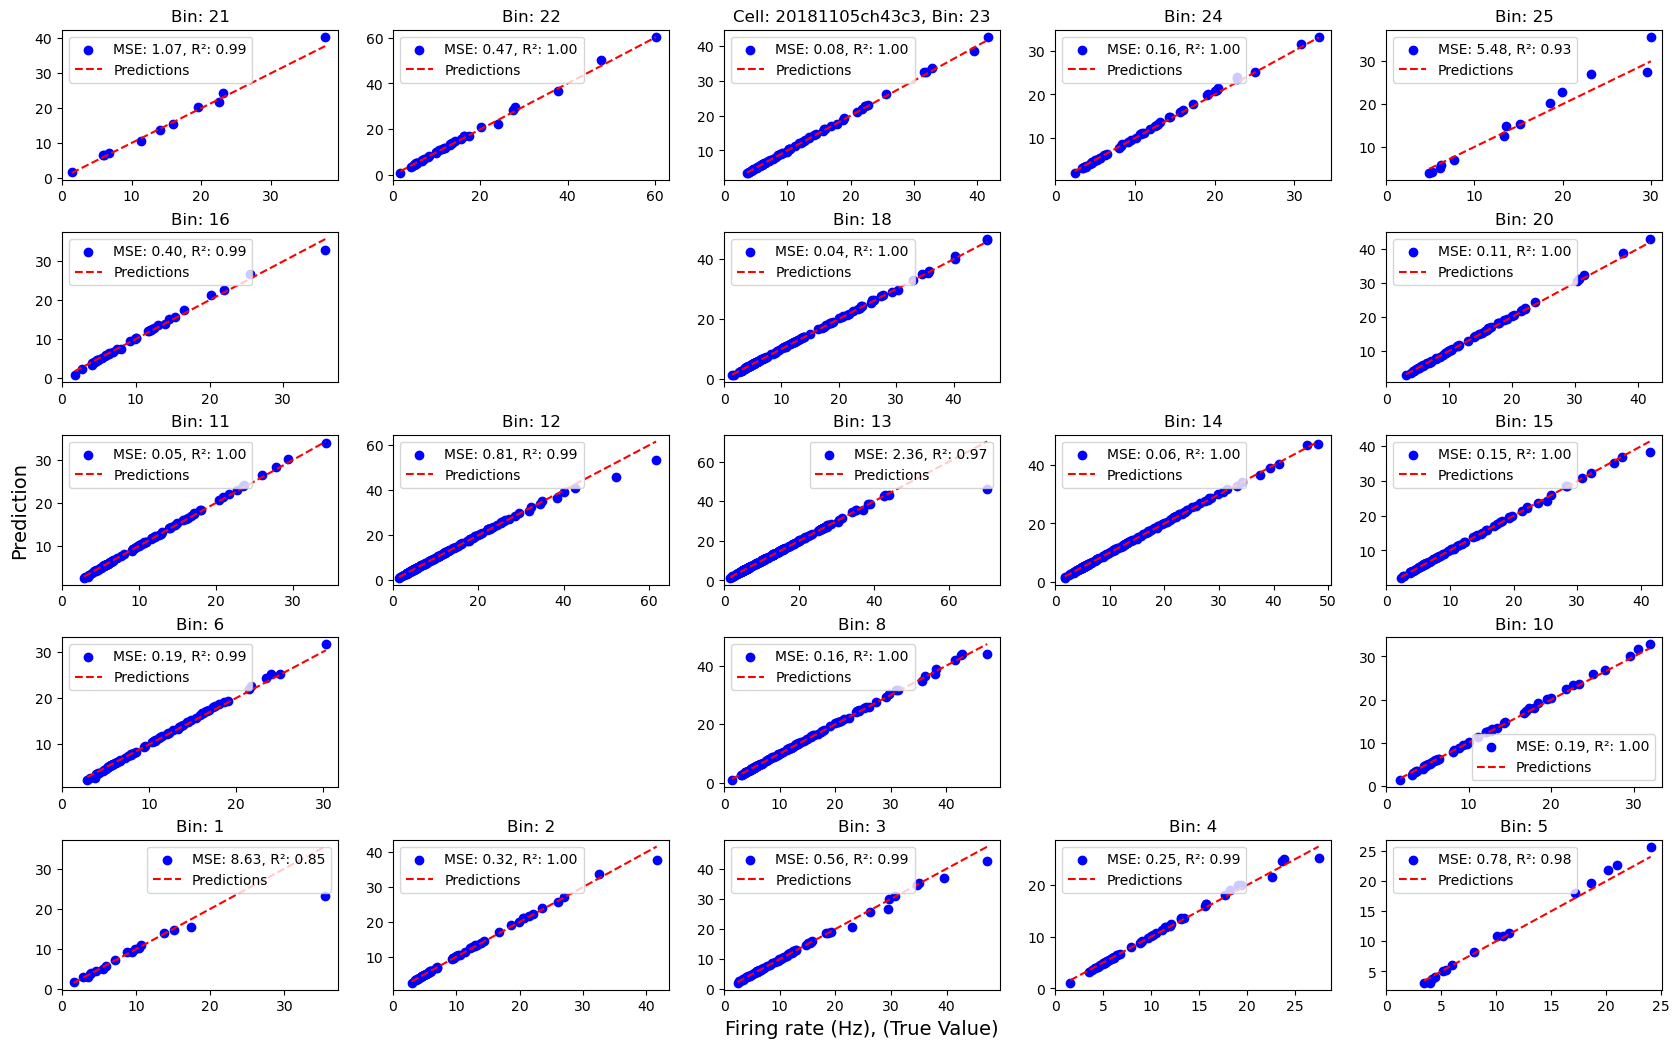

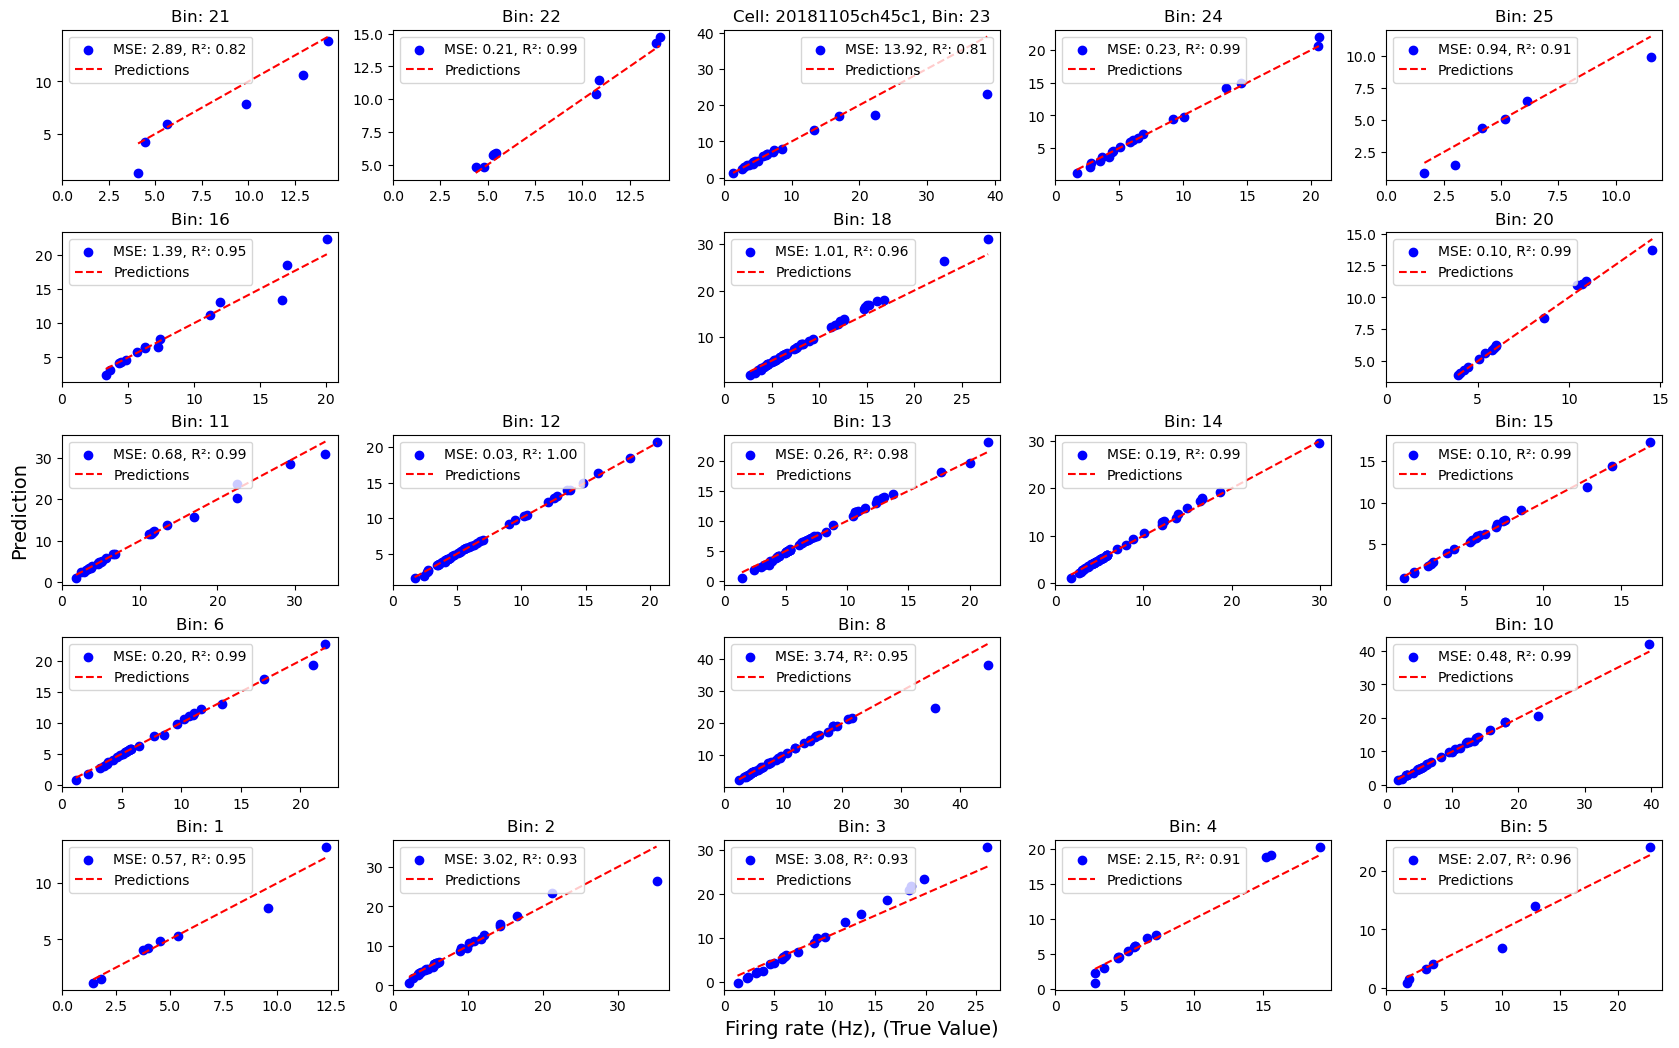

In [104]:
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue

        fig = plt.figure(figsize=(20, 12))
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.35)
        
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            #print(f"Filtered dist for Cell {label}, bin {bin}: {dist}")
            if dist.size < 2:
                #print(f"Not enough values found for cell {label}, {bin}. Skipping train-test split.")
                continue
            train_hz = dist[:-1]
            train_labels = dist[1:]
            train_hz, test_hz, train_labels, test_labels = train_test_split(
                train_hz.reshape(-1, 1), train_labels, test_size=0.3, random_state=42
            )

            model = LinearRegression()
            model.fit(train_hz, train_labels)
            predictions = model.predict(test_hz)

            mse = round(mean_squared_error(test_labels, predictions),4)
            r2 = round(r2_score(test_labels, predictions),4)
            #print(f'Cell: {label}, Bin: {bin}, MSE: {mse}, R²: {r2}')

            fig_pos = (4 - (bin - 1) // 5) * 5 + ((bin - 1) % 5) + 1

            ax = fig.add_subplot(5, 5, fig_pos)
            if fig_pos == 3:
                ax.set_title(f'Cell: {label}, Bin: {bin}')
            else:                
                ax.set_title(f'Bin: {bin}')

            ax.scatter(test_labels, predictions, color='blue', label='Predictions')
            ax.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--', label='Ideal Fit') 
            ax.set_xlim(0, ax.get_xlim()[1])
            ax.legend(labels=[f'MSE: {mse:.2f}, R²: {r2:.2f}', 'Predictions', 'Ideal Fit'])
            if fig_pos == 23:
                ax.set_xlabel('Firing rate (Hz), (True Value)', fontsize=14)
            if fig_pos == 11:
                ax.set_ylabel('Prediction', fontsize=14)
            plt.savefig(f'/Users/jcheng/Documents/neural_decoding/N1ShihChengLabWork/{label}.png', bbox_inches='tight')
            #plt.figure(figsize=(10, 6))
            #plt.scatter(test_labels, predictions, color='blue', label='Predictions')
            #plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--', label='Ideal Fit') 
            #plt.xlabel('True Values')
            #plt.ylabel('Predictions')
            #plt.title(f'Cell: {label}, Bin: {bin}')
            #ax.legend()
            #plt.grid()
            #plt.show()

            
            #print("Training Hz values:", train_hz)
            #print("Test Hz values:", test_hz)


In [103]:
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        
        X_train = []
        y_train = []
        for bin, hz_responses in place_responses_per_cell[cell].items():
            hz_responses = hz_responses[hz_responses > 0]
            random.shuffle(hz_responses)
            if hz_responses.size < 5:
                continue
            split_idx = int(len(hz_responses) * 0.3)       
            hz_responses_train = hz_responses[split_idx:]
            hz_responses_test = hz_responses[:split_idx]
            X_train.extend(hz_responses_train)
            y_train.extend([bin] * len(hz_responses_train))
        X_train = np.array(X_train).reshape(-1, 1)
        y_train = np.array(y_train)
        
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        for bin_num, hz_responses in place_responses_per_cell[cell].items():
            hz_responses_test = hz_responses[:split_idx]
            predicted_bin = model.predict(np.array(hz_responses_test).reshape(-1, 1))                


In [ ]:
#Tomorrow: find out where the grouped cells are and by trial, group those trials up 70% for training data 30% for test data 
#Based on cell activity from the psuedopopulation create prediction model of locations 
#Use that model against the testing data 
#Create distribution of the accuracies based on the days 